# Bella Take Home Assignment

In [130]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [131]:
# Read in data
attributes_df = pd.read_csv("fund_attributes.csv")
cashflows_df = pd.read_csv("fund_cashflows.csv")

In [132]:
# Check df column data types
print("~~~~Fund Attributes Table~~~~~~")
print(attributes_df.dtypes)
print("~~~~Fund Cashflows Table~~~~~~")
print(cashflows_df.dtypes)

~~~~Fund Attributes Table~~~~~~
FUND ID                       int64
ASSET CLASS                  object
REGION                       object
STATE / COUNTY               object
COUNTRY                      object
CITY                         object
VINTAGE / INCEPTION YEAR      int64
STRATEGY                     object
STATUS                       object
PRIMARY REGION FOCUS         object
CORE INDUSTRIES              object
TRANSACTION AMOUNT          float64
INDUSTRIES                   object
GEOGRAPHIC FOCUS             object
FUND CURRENCY                object
dtype: object
~~~~Fund Cashflows Table~~~~~~
FUND ID                 int64
TRANSACTION DATE       object
TRANSACTION TYPE       object
TRANSACTION AMOUNT    float64
dtype: object


In [133]:
# Check for null values
print("~~~~Fund Attributes Table~~~~~~")
print(attributes_df.isnull().sum())

print("~~~~Fund Cashflows Table~~~~~~")
print(cashflows_df.isnull().sum())


~~~~Fund Attributes Table~~~~~~
FUND ID                     0
ASSET CLASS                 0
REGION                      0
STATE / COUNTY              7
COUNTRY                     0
CITY                        4
VINTAGE / INCEPTION YEAR    0
STRATEGY                    0
STATUS                      0
PRIMARY REGION FOCUS        0
CORE INDUSTRIES             4
TRANSACTION AMOUNT          0
INDUSTRIES                  2
GEOGRAPHIC FOCUS            1
FUND CURRENCY               0
dtype: int64
~~~~Fund Cashflows Table~~~~~~
FUND ID               0
TRANSACTION DATE      0
TRANSACTION TYPE      0
TRANSACTION AMOUNT    0
dtype: int64


## Challenge 1: Calculate Performance for Each Fund

Issues:
- Some funds may not have D, C or V

In [134]:
# Isolate the Distribution records 
distributions = cashflows_df[cashflows_df["TRANSACTION TYPE"] == "Distribution"]

# Sum transaction amount grouped by fund id
distributions = distributions.groupby(by="FUND ID").sum("TRANSACTION AMOUNT").reset_index()
distributions.rename(columns={"TRANSACTION AMOUNT": "TOTAL DISTRIBUTION"}, inplace=True)

In [135]:
distributions.head()

,FUND ID,TOTAL DISTRIBUTION
0,5,4.001150e+06
1,9,1.645752e+04
2,20,4.444186e+06
3,26,1.036923e+07
4,29,5.713638e+06


In [136]:
# Some funds may not have Distribution Transaction records. Cross check distributions with unique fund id, and for fund ids not found in distributions, append 0 to the df
fund_ids = attributes_df["FUND ID"].to_list()
fund_ids.sort()

for id in fund_ids:
    if id not in distributions["FUND ID"].values:
        distributions.loc[len(distributions.index)] = [id, 0]

# sort by fund id
distributions.sort_values(by="FUND ID", inplace=True)

# Quick check to make sure all funds are accounted for 
if len(distributions.index) == len(fund_ids):
    print("Every fund's distribution is accounted for")


Every fund's distribution is accounted for


In [137]:
# Isolate the Capital Calls records
capital_calls = cashflows_df[cashflows_df["TRANSACTION TYPE"] ==
                             "Capital Call"]

# Get absolute values of each transaction
capital_calls["TRANSACTION AMOUNT"] = capital_calls["TRANSACTION AMOUNT"].abs()

# Sum up the absolute value of all Capital Calls, C
capital_calls = capital_calls.groupby(
    by="FUND ID").sum("TRANSACTION AMOUNT").reset_index()
capital_calls.rename(columns={"TRANSACTION AMOUNT": "TOTAL CAPITAL CALL"},
                     inplace=True)


# Quick check to make sure all funds are accounted for
if len(capital_calls.index) == len(fund_ids):
    print("Every fund's capital call is accounted for")

Every fund's capital call is accounted for


<ipython-input-137-83afd88db8be>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capital_calls["TRANSACTION AMOUNT"] = capital_calls["TRANSACTION AMOUNT"].abs()


In [138]:
# Convert transaction date column to datetime
cashflows_df["TRANSACTION DATE"] = pd.to_datetime(
    cashflows_df["TRANSACTION DATE"])

# Keep only transaction type of Value and the lastest transaction date
values = cashflows_df[cashflows_df["TRANSACTION TYPE"] == "Value"]
values = values.sort_values("TRANSACTION DATE").groupby("FUND ID").tail(1)

# drop unncessary columns
values.drop(columns=["TRANSACTION DATE", "TRANSACTION TYPE"], inplace=True)

# sort by fund id
values.sort_values(by="FUND ID", inplace=True)

# rename column
values.rename(columns={"TRANSACTION AMOUNT": "LATEST VALUE"}, inplace=True)


In [139]:
# Calculate TVPI
TVPI = distributions.copy()
TVPI["LATEST VALUE"] = values["LATEST VALUE"].values
TVPI["TOTAL CAPITAL CALL"] = capital_calls["TOTAL CAPITAL CALL"].values
TVPI["TVPI"] = TVPI.apply(lambda x: (x["TOTAL DISTRIBUTION"] + x["LATEST VALUE"])/x["TOTAL CAPITAL CALL"], axis=1)

In [140]:
# Sort funds by TVPI values
TVPI.sort_values(by="TVPI", ascending=False, inplace=True)

TVPI.head(10)

,FUND ID,TOTAL DISTRIBUTION,LATEST VALUE,TOTAL CAPITAL CALL,TVPI
63,320,2.007067e+08,0.000000e+00,1.001575e+07,20.039094
62,317,2.010857e+08,0.000000e+00,1.013973e+07,19.831458
510,1780,1.942504e+08,0.000000e+00,1.003645e+07,19.354485
526,1874,1.246852e+08,9.563104e+05,8.895858e+06,14.123593
189,606,1.007995e+08,0.000000e+00,1.000587e+07,10.074036
5,31,7.123504e+07,2.387352e+07,9.848303e+06,9.657355
59,299,8.272646e+07,0.000000e+00,9.978094e+06,8.290808
307,961,8.344349e+07,0.000000e+00,1.006631e+07,8.289379
331,1064,5.097674e+06,7.482508e+07,9.979801e+06,8.008452
493,1710,8.051880e+07,0.000000e+00,1.014880e+07,7.933825


## Challenge 2: What types of Funds Have the Best Performance Profile?

TVPI metric: Anything above 1.00x means an investment grew in value. Anything below 1.00 means the investment shrunk in value. The higher the TVPI, the better for investors. 



### Results:
Based on the average and median TVPI visualized below, Strategies that provide the most attractive returns to investors are:
- Expansion/Late Stage
- Early Stage 
- Venture(General)

Core Industries that provide the most attractive returns to investors are:
- Information Technology, Telecoms & Media
- Information Technology
- Healthcare Technology


In [141]:
# Join TVPI with fund attributes df

funds_df = pd.merge(TVPI, attributes_df, how='inner', left_on="FUND ID", right_on="FUND ID")

funds_df.head(10)

,FUND ID,TOTAL DISTRIBUTION,LATEST VALUE,TOTAL CAPITAL CALL,TVPI,ASSET CLASS,REGION,STATE / COUNTY,COUNTRY,CITY,VINTAGE / INCEPTION YEAR,STRATEGY,STATUS,PRIMARY REGION FOCUS,CORE INDUSTRIES,TRANSACTION AMOUNT,INDUSTRIES,GEOGRAPHIC FOCUS,FUND CURRENCY
0,320,2.007067e+08,0.000000e+00,1.001575e+07,20.039094,Venture Capital,North America,MA,US,Cambridge,1998,Venture (General),Liquidated,North America,"Information Technology, Telecoms & Media",-765678.121989,"Marketing/Advertising, Media, Software, Telecoms",US,USD
1,317,2.010857e+08,0.000000e+00,1.013973e+07,19.831458,Venture Capital,North America,MA,US,Cambridge,1995,Venture (General),Liquidated,North America,"Information Technology, Telecoms & Media",-992595.876270,"Marketing/Advertising, Media, Software, Telecoms",US,USD
2,1780,1.942504e+08,0.000000e+00,1.003645e+07,19.354485,Venture Capital,North America,CA,US,Palo Alto,1996,Venture (General),Liquidated,North America,Information Technology,-513249.397660,Software,US,USD
3,1874,1.246852e+08,9.563104e+05,8.895858e+06,14.123593,Venture Capital,North America,NY,US,New York,2004,Early Stage,Closed,North America,Diversified,-269769.078574,"Financial Services, Healthcare, Marketing/Adve...",US,USD
4,606,1.007995e+08,0.000000e+00,1.000587e+07,10.074036,Venture Capital,North America,TX,US,Dallas,1992,Venture (General),Liquidated,North America,Information Technology,-800297.859430,"Consumer Services, Information Technology, Sem...",US,USD
5,31,7.123504e+07,2.387352e+07,9.848303e+06,9.657355,Venture Capital,North America,CA,US,San Mateo,2007,Early Stage,Closed,North America,Information Technology,-208278.925684,"Information Technology, Software",North America,USD
6,299,8.272646e+07,0.000000e+00,9.978094e+06,8.290808,Venture Capital,North America,CA,US,Menlo Park,2008,Early Stage,Liquidated,North America,Information Technology,-459.304312,"IT Infrastructure, Information Technology, Sof...",North America,USD
7,961,8.344349e+07,0.000000e+00,1.006631e+07,8.289379,Venture Capital,North America,TX,US,Austin,1994,Venture (General),Liquidated,North America,Information Technology,-671972.237158,"Consumer Services, Hardware, Software",US,USD
8,1064,5.097674e+06,7.482508e+07,9.979801e+06,8.008452,Venture Capital,North America,NY,US,New York,2012,Early Stage,Closed,North America,Information Technology,-689447.665462,Information Technology,US,USD
9,1710,8.051880e+07,0.000000e+00,1.014880e+07,7.933825,Venture Capital,North America,CA,US,Palo Alto,1993,Venture (General),Liquidated,North America,Information Technology,-488128.396105,Software,US,USD


In [142]:
# Determine the average TVPI based on Strategy and Core Industries
strategy_avg_df = funds_df.groupby("STRATEGY").mean().reset_index()
industries_avg_df = funds_df.groupby("CORE INDUSTRIES").mean().reset_index()

strategy_median_df = funds_df.groupby("STRATEGY").median().reset_index()
industries_median_df = funds_df.groupby("CORE INDUSTRIES").median().reset_index()

Text(0, 0.5, 'Median TVPI')

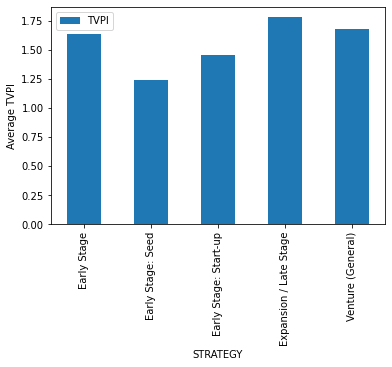

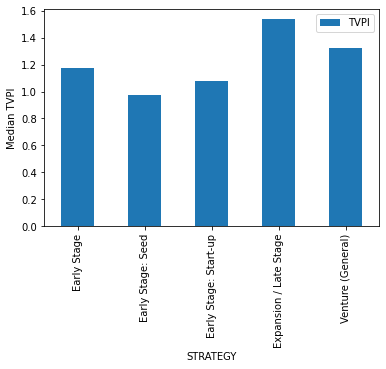

In [143]:
ax = strategy_avg_df.plot(x="STRATEGY", y="TVPI", kind='bar')
ax.set_ylabel("Average TVPI")

axi = strategy_median_df.plot(x="STRATEGY", y="TVPI", kind='bar')
axi.set_ylabel("Median TVPI")

Text(0, 0.5, 'Median TVPI')

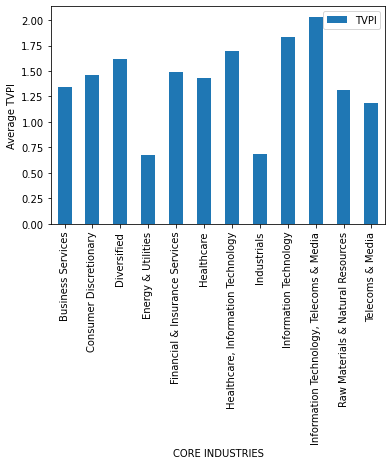

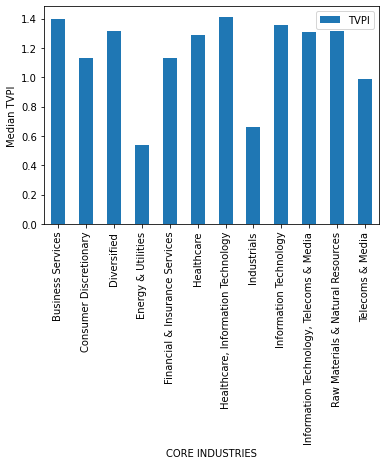

In [144]:
ax = industries_avg_df.plot(x="CORE INDUSTRIES", y="TVPI", kind='bar')
ax.set_ylabel("Average TVPI")

axi = industries_median_df.plot(x="CORE INDUSTRIES", y="TVPI", kind='bar')
axi.set_ylabel("Median TVPI")